/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


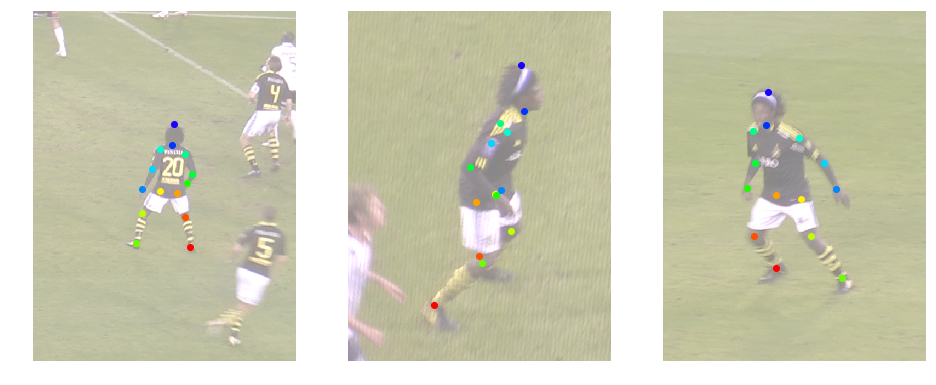

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
import numpy as np
import cv2
from cselect import color as cs
from time import time
import mvpose.data.kth_football2 as kth
from mvpose import pose
import paf_loader

from mvpose.algorithm import settings

params = settings.get_settings(scale_to_mm=1000, max_epi_distance=20)

colors = cs.lincolor(20).astype('float32')/255
FRAME = 40
data_root = Settings['data_root']
seq1_zipname = 'player1sequence2.zip'
seq1_dir = 'Sequence 2'
Im, Calib, pos2d, pos3d = kth.get(data_root, seq1_zipname, seq1_dir, 
                                  FRAME)

fig = plt.figure(figsize=(16,8))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3,cid+1); ax.axis('off')
    ax.imshow(im, alpha=0.5)
    joints = pos2d[:,:,cid]
    for jid, (x,y) in enumerate(joints):
        ax.scatter(x,y,color=colors[jid])

plt.show()

step 1: elapsed 0.893761157989502
step 2: elapsed 0.006177663803100586
step 3: elapsed 0.013538360595703125
step 4: elapsed 0.363999605178833
-------------------------------------------
Handle transitivity:
	Intra:		 0
	Intra(choice):	 0
	Inter:		 0
	Inter(choice):	 0
-------------------------------------------
	Time =  7  ms
	result: 0

	Total cost: 315.9494572880816

# valid points:		 17
# invalid points:	 0
step 5: elapsed 0.009300470352172852
(smart candidate selection) [
	Time =  3  ms
	result: 0

	Total cost: 4.468108515998917
] (smart candidate selection)
step 7: elapsed 0.006050825119018555
elapsed 1.2948708534240723


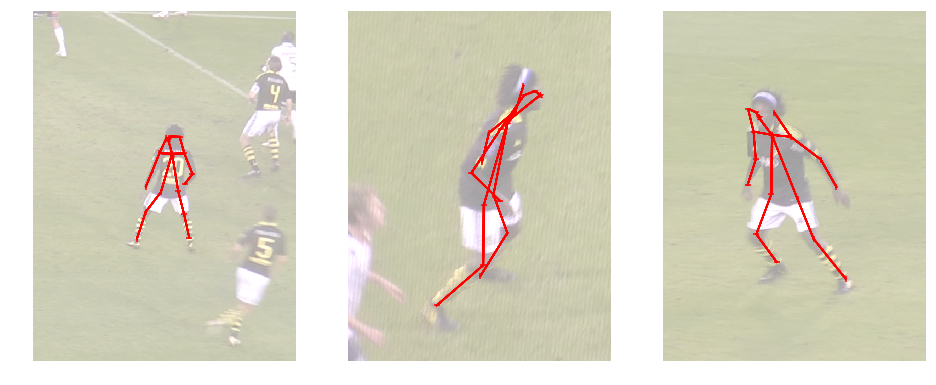

In [2]:
from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human

heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
    'kth' + seq1_zipname[0:-4], Im, FRAME, dir='/home/julian/Temp')
_start = time()
Debug, detections = pose.estimate_heuristic(Calib, heatmaps, pafs,
                                  settings=params, debug=True)
_end = time()
print('elapsed', _end - _start)

Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
    
plt.show()

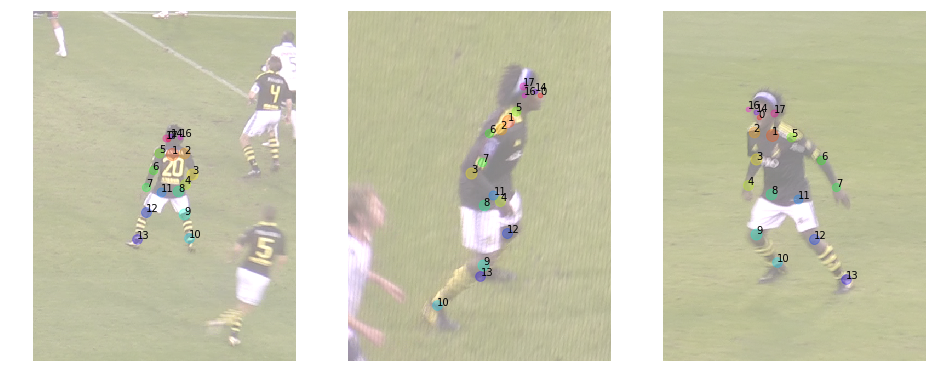

In [3]:
colors = cs.lincolor(20)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.meanshift.centers3d[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        centers2d = cam.projectPoints(centers3d)
        score = centers3d_with_w[:,3]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color=colors[jid], s=score*50, alpha=0.3)
                ax.text(x, y, str(jid))
    
plt.show()

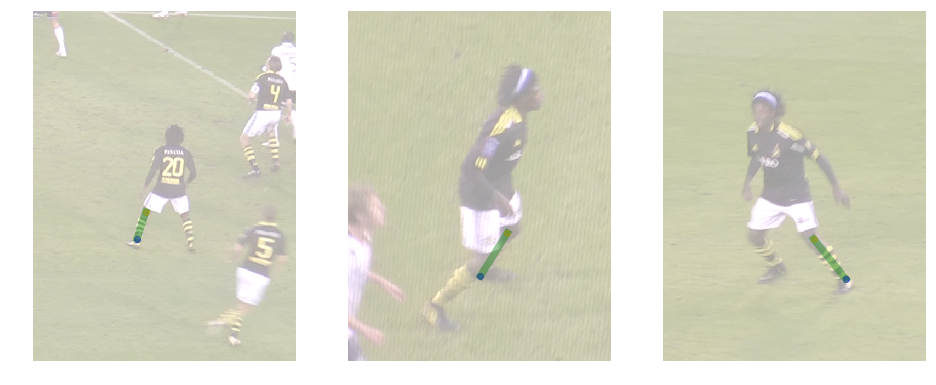

In [4]:
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ

LIMB_ID = 11
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]

W = Debug.limbs3d[LIMB_ID]
n,m = W.shape

candA = Debug.meanshift.centers3d[a][:,0:3]
candB = Debug.meanshift.centers3d[b][:,0:3]
assert n == len(candA) and m == len(candB)

fig = plt.figure(figsize=(16,12))


for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
    ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)
    
    ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='orange', alpha=0.5)
    ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='blue', alpha=0.5)
    
    sq_maskA = np.squeeze(maskA[0])
    sq_maskB = np.squeeze(maskB[0])
    if len(sq_maskA.shape) == 0:
        sq_maskA = np.expand_dims(sq_maskA, axis=0)
    if len(sq_maskB.shape) == 0:
        sq_maskB = np.expand_dims(sq_maskB, axis=0)
    
    for _a in sq_maskA:
        for _b in sq_maskB:
            w = W[_a,_b]
            Ax,Ay = ptsA2d[_a]
            Bx,By = ptsB2d[_b]
            if w > 0:
                ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*10, alpha=0.4)
            elif w > -99999:
                ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*10, alpha=0.4)

plt.show()

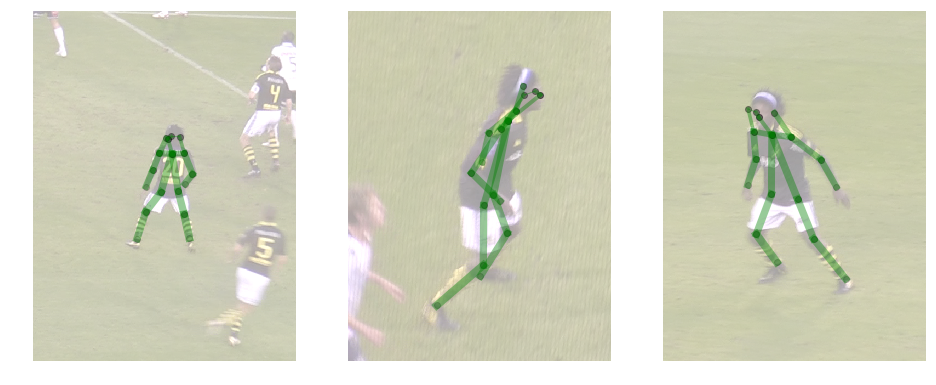

In [5]:
import numpy.linalg as la

fig = plt.figure(figsize=(16,12))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
        candA = Debug.meanshift.centers3d[a][:,0:3]
        candB = Debug.meanshift.centers3d[b][:,0:3]
        W = Debug.limbs3d[lid]
        n, m = W.shape
        assert n == len(candA) and m == len(candB)
        
        ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
        ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)

        ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='black', alpha=0.2)
        ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='black', alpha=0.2)
        
        sq_maskA = np.squeeze(maskA[0])
        sq_maskB = np.squeeze(maskB[0])
        if len(sq_maskA.shape) == 0:
            sq_maskA = np.expand_dims(sq_maskA, axis=0)
        if len(sq_maskB.shape) == 0:
            sq_maskB = np.expand_dims(sq_maskB, axis=0)
        
        min_length, max_length = params.sensible_limb_length[lid]
        
        for _a in sq_maskA:
            for _b in sq_maskB:
                p3dA = candA[_a]
                p3dB = candB[_b]
                distance = la.norm(p3dA - p3dB)
                lstype = '-'
                if distance < min_length or distance > max_length:
                    lstype = ':'
                    
                w = W[_a,_b]
                Ax,Ay = ptsA2d[_a]
                Bx,By = ptsB2d[_b]
                if w > 0:
                    ax.plot([Ax,Bx], [Ay,By], color='green', 
                            linestyle=lstype, linewidth=w*10, alpha=0.4)
                elif w > -99999:
                    ax.plot([Ax,Bx], [Ay,By], color='red', 
                            linestyle=lstype, linewidth=-w*10, alpha=0.4)

plt.show()